# July 2021 Challenge: Quantum State Tomography

[Quantum state tomography](https://en.wikipedia.org/wiki/Quantum_tomography) is the process of reconstructing an unknown quantum state by taking measurements in different bases, and using the result outcomes to estimate its probability amplitides. This is done under the assumption that the same state can be prepared or given to us repeatedly so the process can be performed enough times to build statistical significance. Resource [A] may be helpful as an introduction.

For this challenge, your job is to write a program that performs state tomography for an input state, and also returns the [fidelity](https://en.wikipedia.org/wiki/Fidelity_of_quantum_states) of the predicted outcome with respect to the input quantum state. Resource [B] may be helpful to check your work against.

**Level 1:** Implement a program to perform quantum state tomography for a 1-qubit state. Report the fidelity of the predicted state as function of the number of samples/shots [2].

**Level 2:** Generalize the program to perform quantum state tomography on an n-qubit state. Report the fidelity of the predicted state as function of the number of samples/shots. Keep in mind that you might want to try this for a relatively small number of qubits when you decide to simulate your program. 

**Level 3:** Instead of trying to reconstructing the state through simple repeated measurements, consider implementing a program that uses variational approach to adjust the parameters of a quantum circuit to reconstruct the unknown state. **Hint**: Consider how using the [SWAP test](https://en.wikipedia.org/wiki/Swap_test) in different measurement bases can help acomplish this [1].

**Resources**

[A] Quantum state tomography as a numerical optimization problem. 
Niklas Rohling. https://www.youtube.com/watch?v=Wk6h6NyXkAg  
[B] Qiskit Quantum Tomography Tutorial. https://qiskit.org/documentation/tutorials/noise/8_tomography.html  

**References**

[1] Variational Quantum Circuits for Quantum State Tomograph. Yong Liu, et. al. https://arxiv.org/pdf/1912.07286.pdf  
[2] Quantum State Tomography of a Single Qubit: Comparison of Methods. Roman Schmied. https://arxiv.org/pdf/1407.4759.pdf  
[3] Quantum State Tomography. J. B. Altepeter, et. al. http://research.physics.illinois.edu/QI/Photonics/tomography-files/tomo_chapter_2004.pdf  

# Imports

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from qiskit import *
from qiskit.visualization import plot_histogram
from sympy import Matrix
from scipy.optimize import curve_fit, minimize
from scipy.linalg import eig as eig_solver
from scipy.linalg import sqrtm
from IPython.display import clear_output

# np.seterr(all="ignore")

# Level 1
We consider each combination of Pauli basis to measure each qubit, generally, this would yield $3^n$ measurements where $n$ is the number of qubits. Since we are working with a single qubit state, we will only perform three measurements. To implement these measurements, we use the circuits given [here](https://quantumcomputing.stackexchange.com/a/13611/16092).

To use the measurements to construct the predicted density matrix, we first construct the $\mu$ matrix detailed in [Maximum Likelihood, Minimum Effort](https://arxiv.org/abs/1106.5458) by John A. Smolin, Jay M. Gambetta, and Graeme Smith, and then perform the *Fast algorithm for Subproblem 1* outlined in the same paper.

In [137]:
def one_qubit_tomography(input_state, samples):
    """
    Performs quantum state tomography in a single qubit.
    
    Parameters:
        input_state: np.array
            1-qubit state for which we want to perform quantum state tomography
        samples: int
            Number of samples available of the input state
    
    Returns:
        predicted_state: np.array
            Density matrix of state predicted via quantum state tomography
        fidelity: float
            Fidelity of predicted state in respected to input state
    """
    input_state = np.array(input_state)
    
    circuits = []
    
    # Z basis measurement
    qc = QuantumCircuit(1)
    qc.initialize(input_state, 0)
    qc.measure_all()
    circuits.append(qc)
    
    # X basis measurement
    qc = QuantumCircuit(1)
    qc.initialize(input_state, 0)
    qc.h(0)
    qc.measure_all()
    circuits.append(qc)
    
    # Y basis measurement
    qc = QuantumCircuit(1)
    qc.initialize(input_state, 0)
    qc.sdg(0)
    qc.h(0)
    qc.measure_all()
    circuits.append(qc)
    
    # run circuits
    backend = Aer.get_backend('qasm_simulator')
    job     = execute(circuits, backend, shots=samples)
    counts  = job.result().get_counts()
    
    # get expectation values, ordered the same way as the circuits
    expectation_vals = []
    for count in counts:
        m = (count.get('0', 0) - count.get('1', 0)) / samples
        expectation_vals.append(m)
    
    # calculate µ matrix
    Z  = np.array([[1, 0], [0, -1]])
    X  = np.array([[0, 1], [1, 0]])
    Y  = np.array([[0, -1j], [1j, 0]])
    I  = np.array([[1, 0], [0, 1]])
    mu = (I + expectation_vals[0] * Z + expectation_vals[1] * X + expectation_vals[2] * Y) / 2

    # calculate eigenvalues of µ matrix
    eigen = np.linalg.eig(mu)
    vals  = eigen[0]
    vecs  = eigen[1].transpose()

    # order eigenvalues from largest to smallest
    eig_vals = sorted(vals, reverse=True)
    idx      = []
    for val in eig_vals:
        idx.append(np.where(vals == val)[0][0])
    eig_vecs = []
    for i in idx:
        eig_vecs.append(vecs[i])
        
    # calculate eigenvalues of the density matrix
    accumulator = 0
    lamb_vals   = [None] * len(eig_vals)
    for i in range(len(eig_vals) - 1, -1, -1):
        if eig_vals[i] + (accumulator / (i + 1)) >= 0:
            for j in range(i + 1):
                lamb_vals[j] = eig_vals[j] +  (accumulator / (i + 1))
            break
        else:
            lamb_vals[i] = 0
            accumulator  += eig_vals[i]

    # calculate density matrix
    predicted_state = lamb_vals[0] * np.outer(eig_vecs[0], eig_vecs[0].conj()) \
                        + lamb_vals[1] * np.outer(eig_vecs[1], eig_vecs[1].conj())
    
    # calculate fidelity
    fidelity = input_state.conj().dot(predicted_state).dot(input_state)
    
    return predicted_state, fidelity

In [319]:
density, fidelity = one_qubit_tomography(np.array([np.sqrt(1 / 2), np.sqrt(1 / 2)]), 100)
print('Predicted density matrix:')
display(Matrix(np.round(density, 5)))
print(f'With fidelity: {np.round(fidelity, 5)}') 

Predicted density matrix:


Matrix([
[                0.5, 0.49752 + 0.04975*I],
[0.49752 - 0.04975*I,                 0.5]])

With fidelity: (0.99752+0j)


To calculate the fidelity based on the number of shots, I ran the function defined above for a wide range of shots. Remember that each measurement circuit is ran this number of shots, so in reality the total number of shots is the number passed to the function times three.

In [320]:
shots      = []
fidelities = []

initial_state = np.array([np.sqrt(1 / 2), np.sqrt(1 / 2)])

for i in range(2, 1500):
    shots.append(i)
    density, fidelity = one_qubit_tomography(initial_state, i)
    fidelities.append(fidelity)
    
shots = np.array(shots)

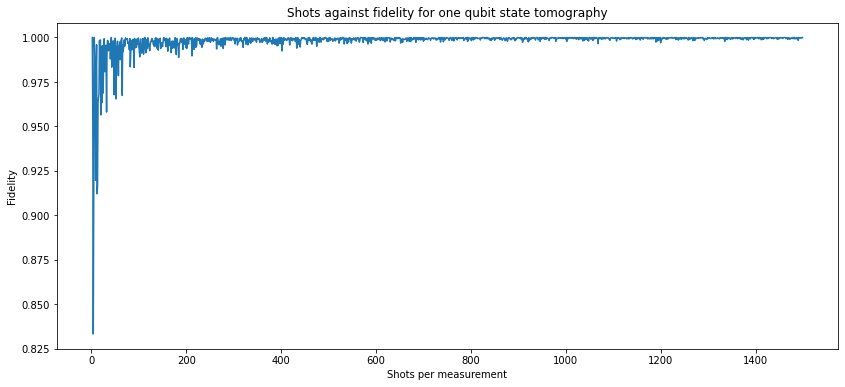

In [321]:
plt.figure(figsize=(14, 6))
plt.plot(shots, np.real(fidelities))
plt.ylabel('Fidelity')
plt.xlabel('Shots per measurement')
plt.title('Shots against fidelity for one qubit state tomography');

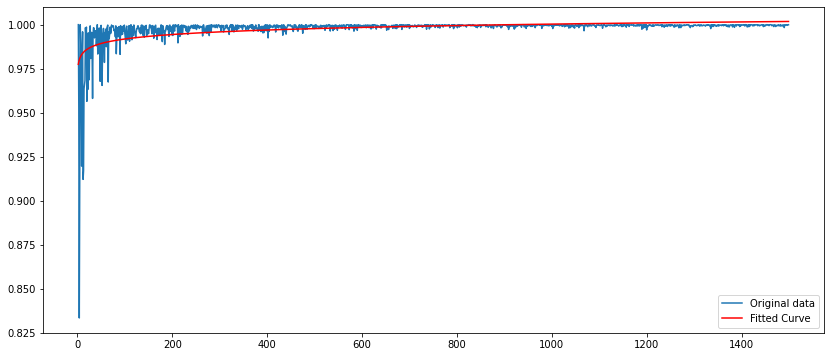

In [322]:
def func(t, a, b, c):
    return a * np.log(t * b) + c
popt, pcov = curve_fit(func, shots, np.real(fidelities), p0=(1, 1, 1))

plt.figure(figsize=(14, 6))
plt.plot(shots, np.real(fidelities), label="Original data")
plt.plot(shots, func(shots, *popt), 'r-', label="Fitted Curve")
plt.legend();

In [323]:
for i in range(2, 1500):
    if func(i, *popt) >= 1:
        print(f'Peak fidelity found at {i} shots')
        break

Peak fidelity found at 917 shots


After running this code for different states assigned to `initial_state`, the logarithm function that fits the fidelities mostly crossed the value 1 after around 900 shots for simple states like $|0\rangle$ and $|+\rangle$. However, for more complicated states like $\begin{pmatrix} 1/\sqrt{3} & \sqrt{2/3} \end{pmatrix}^T$, this fidelity was achieved after around 1100 shots. However, this is because the data in this case is more noise as shown in the graph above. It can easily be seen that fidelities of 1 are already being achieved steadily around the 1000 shots mark. Therefore, 1000 shots should be a good amount for any state.

As you can see below, this number of shots produces good results for various types of initial states. In these I've rounded the expected density matrix up to only three decimals to show the closeness to the actual density matrix.

In [267]:
density, fidelity = one_qubit_tomography(np.array([0, 1]), 1000)
print('Predicted density matrix:')
display(Matrix(np.round(density, 3)))
print(f'With fidelity: {np.round(fidelity, 5)}') 

Predicted density matrix:


Matrix([
[           0.001, -0.023 + 0.017*I],
[-0.023 - 0.017*I,            0.999]])

With fidelity: (0.99918+0j)


In [263]:
density, fidelity = one_qubit_tomography(np.array([np.sqrt(2 / 3), 1j * np.sqrt(1 / 3)]), 1000)
print('Predicted density matrix:')
display(Matrix(np.round(density, 3)))
print(f'With fidelity: {np.round(fidelity, 5)}') 

Predicted density matrix:


Matrix([
[           0.641, -0.016 - 0.474*I],
[-0.016 + 0.474*I,            0.359]])

With fidelity: (0.99389+0j)


In [304]:
density, fidelity = one_qubit_tomography(np.array([np.sqrt(1 / 5), np.sqrt(4 / 5)]), 1000)
print('Predicted density matrix:')
display(Matrix(np.round(density, 3)))
print(f'With fidelity: {np.round(fidelity, 5)}') 

Predicted density matrix:


Matrix([
[          0.203, 0.401 - 0.031*I],
[0.401 + 0.031*I,           0.797]])

With fidelity: (0.99905-0j)


# Level 2
For an easier time working on the generalized version of the above, I first breakdown the above function into smaller functions. Starting with adding the measurement gates for each of the single qubit basis. 

In [3]:
def measure_x_basis(qc, qubit):
    """
    Add a measurement in the X basis to the given qubit
    
    Parameters:
        qc: QuantumCircuit
            Quantum circuit with the qubit to which you want to add the measurement
        qubit: int
            Index of qubit you want to add the measurement to
    """
    qc.h(qubit)
    qc.measure(qubit, qubit)

In [4]:
def measure_y_basis(qc, qubit):
    """
    Add a measurement in the Y basis to the given qubit
    
    Parameters:
        qc: QuantumCircuit
            Quantum circuit with the qubit to which you want to add the measurement
        qubit: int
            Index of qubit you want to add the measurement to
    """
    qc.sdg(qubit)
    qc.h(qubit)
    qc.measure(qubit, qubit)

In [5]:
def measure_z_basis(qc, qubit):
    """
    Add a measurement in the Z basis to the given qubit
    
    Parameters:
        qc: QuantumCircuit
            Quantum circuit with the qubit to which you want to add the measurement
        qubit: int
            Index of qubit you want to add the measurement to
    """
    qc.measure(qubit, qubit)

Now a function that returns all the strings in $\{X, Y, Z\}^n$ (or any other set of values), which will help us get all the possible measurement bases for an $n$-qubit system.

In [6]:
def measurements_strings(n, arr=['X', 'Y', 'Z']):
    strs  = []
    combs = list(itertools.combinations_with_replacement(arr, n))
    for comb in combs:
        for item in set(list(itertools.permutations(comb))):
            strs.append(item)
    return strs

In [7]:
len(measurements_strings(4))

81

Also a function that given an array of operators in $\{I, X, Y, Z\}$ computes their tensor product.

In [8]:
def tensor_operator(arr):
    arr = list(arr)[::-1]
    
    I = np.array([[1, 0], [0, 1]])
    X = np.array([[0, 1], [1, 0]])
    Y  = np.array([[0, -1j], [1j, 0]])
    Z = np.array([[1, 0], [0, -1]])
    
    first = arr.pop(0)
    if first == 'I':
        out = I
    elif first == 'X':
        out = X
    elif first == 'Y':
        out = Y
    else:
        out = Z
        
    for op in arr:
        if op == 'I':
            out = np.kron(out, I)
        elif op == 'X':
            out = np.kron(out, X)
        elif op == 'Y':
            out = np.kron(out, Y)
        else:
            out = np.kron(out, Z)

    return out.astype('complex')

In [9]:
tensor_operator(['X', 'Z'])

array([[ 0.+0.j,  1.+0.j,  0.+0.j,  0.+0.j],
       [ 1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j, -1.+0.j],
       [ 0.+0.j,  0.+0.j, -1.+0.j,  0.+0.j]])

We also need a function that is able to get the expectation value of a given operator. This function should also be able to get the expectation value for operators where the identity matrix is present, although this wasn't measured in any circuit. To achieve this, we default all appearances of the identity to $X$ and ignore the correspodning qubit in the counts.

In [10]:
def get_exp_value(operator_exp, operators_meas, counts, shots):
    """
    Parameters:
        operator_exp: tuple
        operators_meas: list
        counts: list
        shots: int
    """
    new_counts = {}
    ignore = []
    
    # if the operator of the expectation value contains the identity in any qubit
    if 'I' in operator_exp: 
        rep_op = []
        for idx, x in enumerate(operator_exp):
            if x == 'I':
                ignore.append(idx)
                rep_op.append('X')
            else:
                rep_op.append(x) 
    # if there aren't any identities in the expectation operator
    else:                   
        rep_op = operator_exp
        
    # get index of operator_exp in experiment operator_meas, which is the same as in counts
    for idx, x in enumerate(operators_meas):
        if x == tuple(rep_op):
            count_idx = idx

    # create new counts dictionary
    for idx, value in counts[count_idx].items():
        w = idx[::-1]
        for i in ignore:
            w = w[:i] + 'x' + w[i + 1:]
        if w in new_counts.keys():
            new_counts[w] += value
        else:
            new_counts[w] = value
                
    # get expectation value
    exp_value = 0
    for idx, num_meas in new_counts.items():
        meas_val = 1
        for x in idx:
            if x == '1':
                meas_val *= -1
            else:
                pass        
        exp_value += meas_val * num_meas
    exp_value /= shots
        
    return exp_value

Finally, a function that applies the optimization procedure for the $\mu$ matrix obtained from the expectation values and operators.

In [11]:
def mu_optimize(mu, n):
    # calculate eigenvalues of µ matrix
    eigen = np.linalg.eig(mu)
    vals  = eigen[0]
    vecs  = eigen[1].transpose()

    # order eigenvalues from largest to smallest
    eig_vals = sorted(vals, reverse=True)
    idx      = []
    for val in eig_vals:
        idx.append(np.where(vals == val)[0][0])
    eig_vecs = []
    for i in idx:
        eig_vecs.append(vecs[i])
        
    # calculate eigenvalues of the density matrix
    accumulator = 0
    lamb_vals   = [None] * len(eig_vals)
    for i in range(len(eig_vals) - 1, -1, -1):
        if eig_vals[i] + (accumulator / (i + 1)) >= 0:
            for j in range(i + 1):
                lamb_vals[j] = eig_vals[j] +  (accumulator / (i + 1))
            break
        else:
            lamb_vals[i] = 0
            accumulator  += eig_vals[i]

    # calculate density matrix
    predicted_state = np.zeros((2 ** n, 2 ** n), 'complex')
    for idx, lamb_val in enumerate(lamb_vals):
        predicted_state += lamb_vals[idx] * np.outer(eig_vecs[idx], eig_vecs[idx].conj())
    
    return predicted_state

And now the main function.

In [12]:
def tomography(input_state, samples):
    """
    Performs quantum state tomography in an n-qubit state.
    
    Parameters:
        input_state: np.array
            n-qubit state for which we want to perform quantum state tomography
        samples: int
            Number of samples available of the input state
    
    Returns:
        predicted_state: np.array
            Density matrix of state predicted via quantum state tomography
        fidelity: float
            Fidelity of predicted state in respected to input state
    """
    # get number of qubits and bases to be measured in
    n     = int(np.log(len(input_state)) / np.log(2))
    bases = measurements_strings(n)
    
    # generate 3^n circuits with each measurement operator in {X, Y, Z}^n
    circs = []
    for base in bases:
        qc = QuantumCircuit(n, n)
        qc.initialize(input_state)
        for idx, b in enumerate(base):
            if b == 'X':
                measure_x_basis(qc, idx)
            elif b == 'Y':
                measure_y_basis(qc, idx)
            elif b == 'Z':
                measure_z_basis(qc, idx)
        circs.append(qc)
    
    # run circuits
    backend = Aer.get_backend('qasm_simulator')
    job     = execute(circs, backend, shots=samples) # each measurement basis gets a third of the available copies
    counts  = job.result().get_counts()
    
    # get all expectation values
    ops      = measurements_strings(n, arr=['I', 'X', 'Y', 'Z'])[1:] # we need to consider identity operator here
    exp_vals = []
    for op in ops:
        exp_vals.append(get_exp_value(op, bases, counts, samples))

    # calculate µ matrix 
    mu = tensor_operator(['I' for _ in range(n)])
    for idx, op in enumerate(ops):
        mu += exp_vals[idx] * tensor_operator(op)
    mu /= (2 ** n)
    
    # optimize the µ matrix to get the predicted density matrix
    predicted_state = mu_optimize(mu, n)
    
    # calculate fidelity
    fidelity = input_state.conj().dot(predicted_state).dot(input_state)
    
    return predicted_state, fidelity

In [13]:
input_state = np.array([1 / np.sqrt(2), 1 / np.sqrt(2)])

density, fidelity = tomography(input_state, 1000)
print('Predicted density matrix:')
display(Matrix(np.round(density, 3)))
print(f'With fidelity: {np.round(fidelity, 5)}') 

Predicted density matrix:


Matrix([
[        0.503, 0.5 - 0.014*I],
[0.5 + 0.014*I,         0.497]])

With fidelity: (0.9998+0j)


To test the fidelity as a function of the number of shots for different number of qubits $n$, I run the tomography function for the equal superposition state of each $n$ qubits and for various number of shots.

In [338]:
results = []

for i in range(1, 6):
    n              = 2 ** i
    input_state    = np.full((n,), 1 / np.sqrt(n))
    
    fidelities = []    
    for j in range(100, 20000, 100):
        density, fidelity = tomography(input_state, j)
        fidelities.append(fidelity)
    results.append(fidelities)

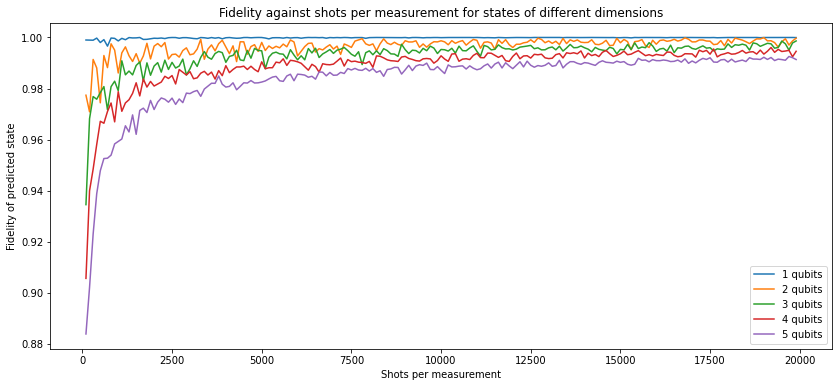

In [339]:
domain = np.array(list(range(100, 20000, 100)))
plt.figure(figsize=(14, 6))
for idx, result in enumerate(results):
    plt.plot(domain, np.real(result), label=f'{idx + 1} qubits')
    plt.legend()
plt.xlabel('Shots per measurement')
plt.ylabel('Fidelity of predicted state')
plt.title('Fidelity against shots per measurement for states of different dimensions');

As you can see, as the number of qubits (dimensions of the state) increases, more shots are needed to achieve a fidelity of 0.99 or higher.

Parameters for 1 qubits: [2.25662320e-04 3.15624272e-03 9.99144752e-01]
Parameters for 2 qubits: [0.00293599 0.02721386 0.98107582]
Parameters for 3 qubits: [5.52056358e-03 7.28413656e+00 9.33027179e-01]
Parameters for 4 qubits: [0.00876006 3.18059885 0.90072793]
Parameters for 5 qubits: [0.0128114  8.60617427 0.84200285]


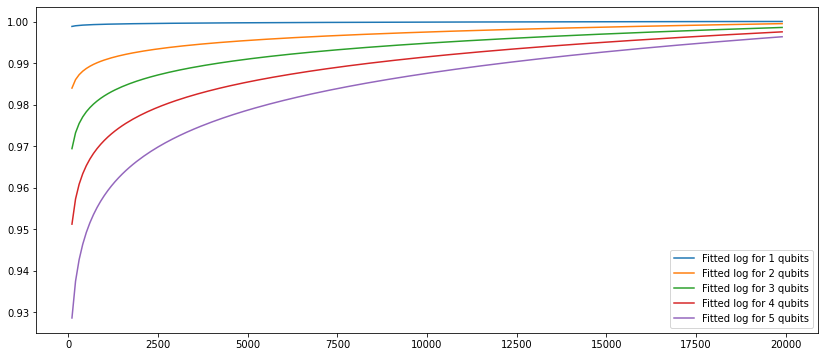

In [340]:
plt.figure(figsize=(14, 6))
parameters = []

def func(t, a, b, c):
    return a * np.log(t * b) + c

for idx, result in enumerate(results):
    popt, pcov = curve_fit(func, domain, np.real(result), p0=(1, 1, 1))
    parameters.append(popt)
    print(f'Parameters for {idx + 1} qubits: {popt}')
    # plt.plot(domain, np.real(result), label=f'{idx + 1} qubits')
    plt.plot(domain, func(domain, *popt), label=f"Fitted log for {idx+1} qubits")
    plt.legend()

In [341]:
print('From fitted data:')
for idx, popt in enumerate(parameters):
    for i in range(1, 20000):
        if func(i, *popt) >= 0.99:
            print(f'Fidelity greater than or equal to 0.99 found at {i} shots for {idx + 1} qubits')
            break

print('\nFrom experimental data:')
for idx, result in enumerate(results):
    for i, r in enumerate(result):
        if r >= 0.99:
            print(f'Fidelity greater than or equal to 0.99 found at {domain[i]} shots for {idx + 1} qubits')
            break

From fitted data:
Fidelity greater than or equal to 0.99 found at 1 shots for 1 qubits
Fidelity greater than or equal to 0.99 found at 768 shots for 2 qubits
Fidelity greater than or equal to 0.99 found at 4165 shots for 3 qubits
Fidelity greater than or equal to 0.99 found at 8382 shots for 4 qubits
Fidelity greater than or equal to 0.99 found at 12083 shots for 5 qubits

From experimental data:
Fidelity greater than or equal to 0.99 found at 100 shots for 1 qubits
Fidelity greater than or equal to 0.99 found at 300 shots for 2 qubits
Fidelity greater than or equal to 0.99 found at 1100 shots for 3 qubits
Fidelity greater than or equal to 0.99 found at 5000 shots for 4 qubits
Fidelity greater than or equal to 0.99 found at 11600 shots for 5 qubits


As you can see, a fitted logarithmic function isn't a great indicator of the number of shots needed to get a fidelity greater than or equal to 0.99, as it overestimates the actual value. This is due that to the fact that after a certain threshold, the fidelities takes value between 0.98 and 1 (this range gets smaller as the number of qubits decreases) that don't seem to follow any pattern/function. Therefore, a better indicator is to get the said threshold from the experimental data, as shown above.

However, when we try to find a pattern in the number of shots needed depending on the number of qubits using the experimental data, no clear pattern arises. To see something, we may need to run the simulations for smaller steps than 100 shots, but that would be too computational intensive for the moment. The table for the experimental data is:

| # qubits | # shots | first difference | second difference |
|---|---|---|---|
|1|100|N/A|N/A|
|2|300|200|N/A|
|3|1100|800|600|
|4|5000|3900|3100|
|5|11600|6600|2700|

Using the fitted data, we get the following table:

| # qubits | # shots | first difference | second difference |
|---|---|---|---|
|1|100|N/A|N/A|
|2|768|668|N/A|
|3|4165|3397|2729|
|4|8382|4217|820|
|5|12083|3701|-516|

Again, no particularly interesting pattern arises from this table alone. But using the predicted number of shots for 5 qubits yields good results when trying it out in an equal superposition state, as it is shown below.

In [16]:
n           = 2 ** 5
input_state = np.full((n,), 1 / np.sqrt(n))

density, fidelity = tomography(input_state, 12100)
print(f'Fidelity: {np.round(fidelity, 5)}') 

Fidelity: (0.98879-0j)


# Level 3
Here, a viariational algorithm for quantum state tomography is implemented based on the description for pure states given in section 2 of [*Variational Quantum Circuits for Quantum State Tomography*](https://arxiv.org/abs/1912.07286).

First we define a function that builds a variational circuit (ansatz) using a set of parameters. The variational circuit implemented here consists of alternating $R_y$ and $R_x$ gates with alternating $CNOT$ gates in each layer to enable entanglement. This construction is based on that from section 2 of [*Variational Quantum Circuits for Quantum State Tomography*](https://arxiv.org/abs/1912.07286), but the structure of the $CNOT$ gates in each section is altered.

In [2]:
def ansatz(n, d, qc, reg, params):
    """
    Build ansatz needed for variational circuit.
    
    Parameters:
        n: int
            Size of the ansatz circuit
        d: int
            Number of layers for the ansatz; depth
        qc: QuantumCircuit
            Qiskit quantum circuit in which to add the ansatz
        reg: QuantumRegister
            Register to which you want to add the ansatz
        params: np.array
            Numpy array with the parameters for the rotation gates in the ansatz
    """
    arr_idx = 0
    
    for i in range(1, d + 1):
        # even layers
        if i % 2 == 0:
            for j in range(n):
                qc.ry(params[arr_idx], reg[j])
                arr_idx += 1
            for k in range(1, n):
                if k + 1 > n:
                    break
                else:
                    qc.cz(reg[0], reg[k])
                    
        # odd layers
        else:
            for j in range(n):
                qc.ry(params[arr_idx], reg[j])
                arr_idx += 1
            for k in range(n - 2, -1, -1):
                if k + 1 > n - 1:
                    break
                else:
                    qc.cz(reg[-1], reg[k])
    
    # extra final layer
    for i in range(n):
        qc.rx(params[arr_idx], reg[i])
        arr_idx += 1

Then we define a function that is able to perform the swap test between two registers of equal size in the same circuit. We will use this to calculate the loss function of the algorithm later on. 

In [3]:
def swap_test(n, qc, reg_1, reg_2, aux, aux_c, basis=0):
    """
    Add swap test circuit between two registers using an auxilary qubit.
    
    Paremetrs:
        n: int
            Size of both registers to which we apply the SWAP test
        qc: QuantumCircuit
            Quantum circuit containing all the qubits we are going to act on
        reg_1: QuantumRegister
            First register on the test
        reg_2: QuantumRegister
            Second register on the test
        aux: QuantumRegister
            Register with the ancilla qubit used in the SWAP test
        aux_c: ClassicalRegister
            Register to store measurement value of the aux quantum register
        basis: int
            Basis in which to perform the SWAP test; 0 for X, 1 for Y and 2 for Z
    """
    # change states in registers to compare to the given basis
    if basis == 0:
        pass
    elif basis == 1:
        qc.sdg(reg_1)
        qc.h(reg_1)
        qc.sdg(reg_2)
        qc.h(reg_2)
    elif basis == 2:
        qc.h(reg_1)
        qc.h(reg_2)
    
    qc.h(aux)
    for i in range(n):
        qc.cswap(aux, reg_1[i], reg_2[i])
    qc.h(aux)
    qc.measure(aux, aux_c)

Using the two functions above, we can construct a function that calculates the loss function as detailed in the paper already mentioned. This takes the target state and initializes that state into one register of size $n$. Another register of the same size is used to build the variational circuit with some parameters. Once these two steps are done, the SWAP test is performed and the following formula is used to calculate the loss function:

$$
loss = 1 - \sqrt{1 - 2 p_1},
$$

where $p_1$ is the probability of the ancilla qubit used in the SWAP test to be in the state $|1\rangle$.

In [7]:
def loss_func(params, ansatz, target_state, n, d, shots, backend):
    """
    Calculate loss function of variational circuit used to reconstruct the target state via state tomography.
    
    Parameters:
        params: np.array
            Array with the parameters of the variational circuit to try
        ansatz: func
            Function that takes a circuit of size n and a set of parameters to add a parametrized circuit to it
            Must be of the form: ansatz(n, d, qc, reg, params)
        target_state: np.array
            Statevector of the target state in which we are performing the tomography
        n: int
            Number of qubits needed to represent the target state
        d: int
            Desired depth of the variational circuit
        shots: int
            Number of times to run the quantum circuit
        backend: IBMQBackend
            Backend to run the quantum circuit in
            
    Returns:
        loss: float
            Calculated loss value through the SWAP test
    """
    loss_vals = []
    
    for i in range(3):
        # initialize all registers and quantum circuit
        reg_1 = QuantumRegister(n, 'pure')
        reg_2 = QuantumRegister(n, 'var')
        aux   = QuantumRegister(1, 'aux')
        aux_c = ClassicalRegister(1, 'c')
        qc    = QuantumCircuit(reg_1, reg_2, aux, aux_c)

        # initialize target state in register 1
        init = QuantumCircuit(n) 
        init.initialize(target_state)
        init = transpile(init, basis_gates=['cx', 'u'])
        init_gate = init.to_gate(label=' init ')
        qc.append(init_gate, reg_1)

        # add variational circuit in register 2
        ansatz(n, d, qc, reg_2, params)

        # perform swap test between registers 1 and 2
        swap_test(n, qc, reg_1, reg_2, aux, aux_c, basis=i+1)

        # run circuit to calculate the loss function
        job     = backend.run(transpile(qc, backend), shots=shots)
        counts  = job.result().get_counts()
        if 1 - 2 * (counts.get('1', 0) / shots) < 0: # avoid rounding errors
            loss = 0
        else:
            loss = 1 - np.sqrt(1 - 2 * (counts.get('1', 0) / shots))
        loss_vals.append(loss)
    
    clear_output(wait=True)
    print(f'X: {loss_vals[0]}. Y: {loss_vals[1]}. Z: {loss_vals[2]}. Avg: {np.average(loss_vals)}')
    
    return np.average(loss_vals)

To test that this loss function works, I'll use an already built optimizer from [SciPy](https://www.scipy.org) that has many optmization methods available. The target state will be randomly generated. The number of layers and shots is quite arbitrary at this point as well as the initial guess for the parameters, which simply is all $0$s. And we use the QASM simulator to run our circuits.

In [8]:
n = 2
d = 5
shots   = 10000
target  = np.random.rand(2 ** n)
target  = target / np.linalg.norm(target)
# target = np.full(2 ** n, 1 / np.sqrt(2 ** n)) # equal superposition of all basis states
guess   = [0 for _ in range(n * d + n)]
backend = Aer.get_backend('qasm_simulator')    
    
op_result = minimize(loss_func, guess, args=(ansatz, target, n, d, shots, backend), method='COBYLA')
print(f'Target state: {target}')
print(f'Calculated parameters: {op_result.x}')
print(f'With loss value: {op_result.fun}')

X: 0.0004000800320159703. Y: 0.0006001801080810498. Z: 0.0003000450135051125. Avg: 0.00043343505120071085
Target state: [0.17874835 0.47691638 0.54261976 0.66795479]
Calculated parameters: [ 0.91775659  0.54839631  0.77820996  0.42159966  0.07590215 -0.05597055
  0.0806014   1.41798112 -0.29500414  0.1108828   0.1156926   0.04097329]
With loss value: 0.00043343505120071085


As you can see, the function is able to optimize the parameters really good, as it returns parameters with a small final loss value. We can construct a variational circuit just as the one used in the loss function to check out what state the parameters found by the optimization produce.

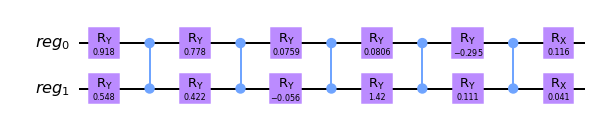

Ansatz has {'ry': 10, 'cz': 5, 'rx': 2}


Matrix([[0.18303 - 0.03883*I, 0.47793 - 0.02423*I, 0.54171 - 0.04215*I, 0.66262 - 0.04121*I]])

In [9]:
reg = QuantumRegister(n, 'reg')
qc  = QuantumCircuit(reg)

ansatz(n, d, qc, reg, op_result.x)
display(qc.draw('mpl'))

backend = Aer.get_backend('statevector_simulator')
result  = execute(qc, backend).result()
vector  = result.get_statevector()[None]
print(f'Ansatz has {dict(qc.count_ops())}')
Matrix(np.round(vector, 5))

Although we see some imaginary values in the statevector above while the target state contians only real values, the amount of the imaginary coefficients can be greatly reduced by factoring out a global phase out of the statevector. This would still leave a small coefficient for $i$ in the statevector, but the similarity of the state got from the circuit and the target state is good as indicated by the loss function. 

To see the similarity clearly, we can run the circuit using the QASM simulator to get the estimated probability distribution of the predicted and target states.

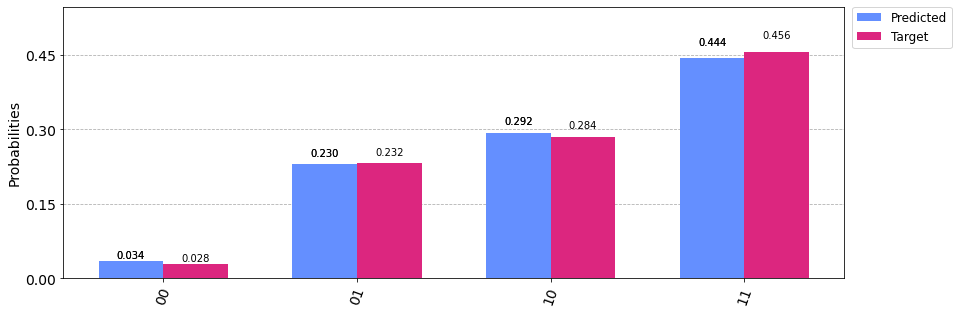

In [10]:
reg = QuantumRegister(n)
qc  = QuantumCircuit(reg)

ansatz(n, d, qc, reg, op_result.x)
qc.measure_all()

qc2 = QuantumCircuit(n)
qc2.initialize(target)
qc2.measure_all()

backend = Aer.get_backend('qasm_simulator')
result  = execute([qc, qc2], backend, shots=10000).result()
counts  = result.get_counts()

plot_histogram(counts, figsize=(14,5), legend=['Predicted', 'Target'])

Although visualizing the counts might be a good indicator at first thought, it doesn't reflect the actual state of our quantum system to perfection, since the QASM simulator simulates the randomness of a quantum computer and therefore the counts for the predicted and target states will not be the same even if the states are exactly the same. Therefore, we can introduce another value.

This other good indicator of the accuracy of the predicted state is the state fidelity. This is defined as:

$$
F(\rho_1, \rho_2) = Tr\left[\sqrt{\sqrt{\rho_1} \rho_2 \sqrt{\rho_1}}\right]^2,
$$

where $\rho_1$ and $\rho_2$ are the density matrices of the states we are comparing. Since we know that we will only be comparing pure states, the expression for fidelity can be simplified to

$$
F(\rho_1, \rho_2) = \langle\psi_1|\psi_2\rangle\langle\psi_2|\psi_1\rangle = |\langle\psi_2|\psi_1\rangle|^2,
$$

where $\rho_i = |\psi_i\rangle\langle\psi_i|$.

In [11]:
fidelity = np.abs(target.conj().dot(vector[0])) ** 2
print(f'Fidelity of predicted state compared to target state: {fidelity}')

Fidelity of predicted state compared to target state: 0.9991361000514039


Determining the number of layers $d$ optimal for each number of qubits $n$ is an interesting task. Through testing, the following roughly optimal values (optimal considering both runtime and fidelity of predicted state against target state) are found:

|$n$|$d$|
|---|---|
|1|2|
|2|3|
|3|4|
|4|5|

However, although this values for $d$ work really well for most states, there are some target states for which this number of layers isn't sufficient. To account for this, we can add more layers to our variational circuit, or repeat the optimizing process while the loss function gives a value greater than or equal to $0.01$. There is no right or wrong choice for that, as the effectiveness of the algorithm depends on the ansatz choice which in turn depends on the target state and might need further experimentation to get right.

To account for this flexibility, we can go ahead and already implement the general tomography function that only takes in a target state and tries to reproduce it.

In [21]:
def tomography(ansatz, layers, num_params, loss_func, target, shots, method='COBYLA', repeat=False):
    """
    Performs state tomography on the target state using a variational algorithm.
    
    Parameters:
        ansatz: func
            Function that takes a circuit of size n and a set of parameters to add a parametrized circuit to it
            Must be of the form: ansatz(n, layers, qc, reg, params)
        layers: int
            Number of layers of the ansatz to add to the variational circuit
        num_params: int
            Number of parameters the specified ansatz needs
        loss_func: func
            Function that adds the cost function to the circuit, which uses the SWAP test
            Must be of the form: loss_func(params, ansatz, target_state, n, layers, shots, backend)
        target: np.array
            2^n normalized array with the target statevector
        shots: int
            Number of available shots for each measurement of the variational circuit
        method: str
            String with name of SciPy optimizer to use to optimize the parameters; defaults to COBYLA
        repeat: bool
            If True, it will repeat the optimization procedure until the final loss value is less than 0.01
            
    Returns:
        op_result.x: np.array
            Array with the optimized parameters
        op_result.fun: float
            Value of the given loss function with the found optimal parameters
    """
    n = int(np.log(len(target)) / np.log(2))
    
    guess   = [0 for _ in range(num_params)]
    backend = Aer.get_backend('qasm_simulator')    
    
    op_result = minimize(loss_func, guess, args=(ansatz, target, n, layers, shots, backend), method=method)
    
    if repeat:
        loss_val  = op_result.fun
        while loss_val >= 0.01:
            params    = op_result.x            
            op_result = minimize(loss_func, params, args=(ansatz, target, n, layers, shots, backend), method=method)
            loss_val  = op_result.fun
    
    return op_result.x, op_result.fun

In [20]:
num_qubits = 3
layers     = 4
num_params = num_qubits * (layers + 1)
target     = np.random.rand(2 ** num_qubits)
target     = target / np.linalg.norm(target)
shots      = 10000

tomography(ansatz, layers, num_params, loss_func, target, shots, 'COBYLA', repeat=True)

X: 0.0011006056664164543. Y: 0.0015011266906707066. Z: 0.0017014474617325082. Avg: 0.0014343932729398896


(array([ 1.85334458,  1.11375543,  1.01091467,  0.55874179,  0.16858715,
        -0.13331855, -0.24708919, -0.51150903, -0.31604596,  0.13370372,
        -0.25932827, -1.16169993,  0.13753899, -0.12170018, -0.02577196]),
 0.0014343932729398896)

As you can see, the general tomography function that we have created has a lot of flexibility. It is done this way because variational algorithms heavily depend on the choice of ansatz and loss function, which can be chosen carefully if previous knowledge about the target state is given. This previous knowledge can help make the ansatz circuit smaller in depth and therefore improve the runtime and use of resources of the whole algorithm. 

Further work with this algorithm can be done to implement a specific optimization method for this problem, as now the COBYLA method we are using isn't the perfevt choice for what we want to achieve. Also, research in the ansatz design is an active field within variational algorithms and can have applications to our algorithm, given that we know something about the target state we can use an optimal ansatz and if no knowledge is known, at least we can use a somewhat efficient ansatz that is able to reach all states in $\mathcal{H}^n$.